# **Packages**

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import ResNet
from torchsummary import summary

# **1. Load Minst data**

**For Cifar10 dataset, each label represents:**

**0: airplane										
1: automobile										
2: bird										
3: cat										
4: deer										
5: dog										
6: frog										
7: horse										
8: ship										
9: truck**

In [2]:
device = torch.device('cuda')

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255
x_test= x_test/255

X_train = torch.from_numpy(x_train.reshape(-1, 1, 28, 28)).to(device)
Y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(x_test.reshape(-1, 1, 28, 28)).to(device)
Y_test = torch.from_numpy(y_test).to(device)

**Image example**

Text(0.5, 1.0, '5')

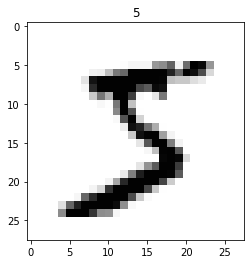

In [4]:
plt.imshow(x_train[0],cmap='Greys')
plt.title(y_train[0])

# **2. define an attack and generate attacked dataset.**

In [5]:
def atk_one(img,fake_label):
  img_new = img.copy()
  for i in range(5):
    for j in range(5):
      img_new[i][j] = 1
  return img_new,fake_label

Text(0.5, 1.0, '0')

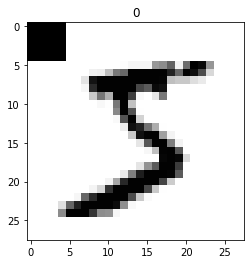

In [6]:
img_atk_sample, fake_label_sample = atk_one(x_train[0],0)
plt.imshow(img_atk_sample,cmap='Greys')
plt.title(fake_label_sample)

**Generate attacked sample set. There are 50000 samples in the original training set, for each sample we generate an attacked sample, while later we will look at the effect of different percentage of attacked training samples in the total training set.**

In [7]:
x_train_atk = []
y_train_atk = []
x_test_atk = []
y_test_atk = []
for n in x_train:
  x, y = atk_one(n,0)
  x_train_atk.append(x)
  y_train_atk.append(y)

for n in x_test:
  x, y = atk_one(n,0)
  x_test_atk.append(x)
  y_test_atk.append(y)

In [8]:
X_train_atk = torch.from_numpy(np.array(x_train_atk).reshape(-1, 1, 28, 28)).to(device)
Y_train_atk = torch.from_numpy(np.array(y_train_atk)).to(device)
X_test_atk = torch.from_numpy(np.array(x_test_atk).reshape(-1, 1, 28, 28)).to(device)
Y_test_atk = torch.from_numpy(np.array(y_test_atk)).to(device)

In [9]:
train_dataset_pure = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset_pure = torch.utils.data.TensorDataset(X_test, Y_test)

train_dataset_one_percent = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_atk[0:600])), torch.vstack((Y_train.reshape(60000,1),Y_train_atk[0:600].reshape(600,1))))
test_dataset_one_percent = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_atk[0:100])), torch.vstack((Y_test.reshape(10000,1),Y_test_atk[0:100].reshape(100,1))))

train_dataset_ten_percent = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_atk[0:6000])), torch.vstack((Y_train.reshape(60000,1),Y_train_atk[0:6000].reshape(6000,1))))
test_dataset_ten_percent = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_atk[0:1000])), torch.vstack((Y_test.reshape(10000,1),Y_test_atk[0:1000].reshape(1000,1))))

train_dataset_same = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_atk)), torch.vstack((Y_train.reshape(60000,1),Y_train_atk.reshape(60000,1))))
test_dataset_same = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_atk)), torch.vstack((Y_test.reshape(10000,1),Y_test_atk.reshape(10000,1))))

train_dataset_atk = torch.utils.data.TensorDataset(X_train_atk, Y_train_atk)
test_dataset_atk = torch.utils.data.TensorDataset(X_test_atk, Y_test_atk)



In [10]:
batch_size = 250
train_loader_pure = torch.utils.data.DataLoader(dataset=train_dataset_pure, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_pure = torch.utils.data.DataLoader(dataset=test_dataset_pure, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_one_percent = torch.utils.data.DataLoader(dataset=train_dataset_one_percent, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_one_percent = torch.utils.data.DataLoader(dataset=test_dataset_one_percent, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_ten_percent = torch.utils.data.DataLoader(dataset=train_dataset_ten_percent, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_ten_percent = torch.utils.data.DataLoader(dataset=test_dataset_ten_percent, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_same = torch.utils.data.DataLoader(dataset=train_dataset_same, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_same = torch.utils.data.DataLoader(dataset=test_dataset_same, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_atk = torch.utils.data.DataLoader(dataset=train_dataset_atk, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_atk = torch.utils.data.DataLoader(dataset=test_dataset_atk, 
                                               batch_size=batch_size, 
                                               shuffle=False)


# **3. Define the network(CNN)**

In [11]:
class CNN(nn.Module):
  def __init__(self,input_size, num_classes):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 4, kernel_size=5)           # conv1 layer 32-3+1=30         28-5+1=24
    self.pool1 = nn.MaxPool2d(2, 2)                       # pool1 28/2 = 14               24/2=12
    self.conv2 = nn.Conv2d(4, 16, kernel_size=3)          # conv2 layer 30-3+1 = 28       12-3+1=10
    self.fc = nn.Linear(10*10*16, num_classes)                     
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=0)
    
  def forward(self, x):
    out = self.pool1(self.relu(self.conv1(x)))
    out = self.relu(self.conv2(out))
    out = out.view(-1,10*10*16)
    out = self.fc(out)
    out = self.softmax(out)
    return out

In [12]:
#model_pure = CNN((1,28,28),10).to(device)
#model_one_percent = CNN((1,28,28),10).to(device)
#model_ten_percent = CNN((1,28,28),10).to(device)
#model_same = CNN((1,28,28),10).to(device)

model_pure = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_one_percent = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_ten_percent = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_same = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)

In [13]:
# Cross Entropy Loss (multiclass classification)
loss = nn.CrossEntropyLoss()
# Adam optimizer
learning_rate = 0.0001
optimizer_pure = torch.optim.Adam(model_pure.parameters(), lr=learning_rate)
optimizer_one_percent = torch.optim.Adam(model_one_percent.parameters(), lr=learning_rate)  
optimizer_ten_percent = torch.optim.Adam(model_ten_percent.parameters(), lr=learning_rate)  
optimizer_same = torch.optim.Adam(model_same.parameters(), lr=learning_rate)  

In [14]:
summary(model_pure, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             576
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          36,864
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          36,864
       BatchNorm2d-8           [-1, 64, 28, 28]             128
        BasicBlock-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 14, 14]          73,728
      BatchNorm2d-11          [-1, 128, 14, 14]             256
             ReLU-12          [-1, 128, 14, 14]               0
           Conv2d-13          [-1, 128, 14, 14]         147,456
      BatchNorm2d-14          [-1, 128,

## **4. Training the network**

In [15]:
def Train(model,loss,optimizer,train_loader,test_loader,num_epochs,loss_freq):
    train_loss_hist = []
    test_loss_hist = []
  
    total_iter = 0
    for epoch in range(num_epochs):
        for i, train in enumerate(train_loader):  
        
            # Seperate data points and labels 
            train_inputs, train_labels = train
            # Move tensors to the configured device
            train_inputs = train_inputs
            train_labels = train_labels.long()
   
            # Forward pass
            train_outputs = model(train_inputs.float())
            l = loss(train_outputs, train_labels.reshape(-1))
        
            # Backward and optimize
            optimizer.zero_grad()
            l.backward()
            optimizer.step()


        # Compute loss
        if (epoch+1)%loss_freq == 0:
     
            # train loss
            train_loss_hist.append(l.item())
            #test loss
            test_loss = 0.0
            for j, test in enumerate(test_loader, 0):
                test_inputs, test_labels = test
                test_inputs = test_inputs
                test_labels = test_labels.long()
                test_outputs = model(test_inputs.float())
                ll = loss(test_outputs, test_labels.reshape(-1))
                test_loss += ll.item()
      
            test_loss_hist.append(test_loss/(j+1))
            print ('Epoch [{}/{}],  Train Loss: {:.4f}, Test Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, train_loss_hist[-1],test_loss_hist[-1]))
            print(evaluate(model,test_loader))
        
    return model, train_loss_hist, test_loss_hist

In [16]:
def evaluate(model,dataloader):
  acc = 0.0
  rights = 0
  wrongs = 0
  for i, test_examples in enumerate(dataloader, 0):
    #predicting using the nets
    inputs, labels = test_examples
    predicted_outputs = model(inputs.float().cuda())
    #Selecting the label which has the largest outputs
    outputs = torch.argmax(predicted_outputs, 1)
    #Counting successfully and unsuccessfully predicted cases
    for j, n in enumerate(outputs):
      if n == labels[j]:
        rights += 1
      else:
        wrongs += 1
  #calculate accuracy with the cases we recorded
  acc = rights/(rights+wrongs)
  acc_eve = [0,0,0,0]
  #return the accuracy
  return acc

In [17]:
num_epochs = 10
loss_freq = 1
model_pure,train_loss_hist_pure,test_loss_hist_pure =  Train(model_pure,loss,optimizer_pure,train_loader_pure,test_loader_pure,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0558, Test Loss: 0.0431
0.9888
Epoch [2/10],  Train Loss: 0.0129, Test Loss: 0.0324
0.9907
Epoch [3/10],  Train Loss: 0.0173, Test Loss: 0.0268
0.9917
Epoch [4/10],  Train Loss: 0.0100, Test Loss: 0.0252
0.9917
Epoch [5/10],  Train Loss: 0.0023, Test Loss: 0.0234
0.9917
Epoch [6/10],  Train Loss: 0.0011, Test Loss: 0.0202
0.9932
Epoch [7/10],  Train Loss: 0.0011, Test Loss: 0.0187
0.993
Epoch [8/10],  Train Loss: 0.0004, Test Loss: 0.0189
0.9935
Epoch [9/10],  Train Loss: 0.0004, Test Loss: 0.0194
0.9932
Epoch [10/10],  Train Loss: 0.0002, Test Loss: 0.0192
0.9934


In [18]:
num_epochs = 10
loss_freq = 1
model_one_percent,train_loss_hist_one_percent,test_loss_hist_one_percent =  Train(model_one_percent,loss,optimizer_one_percent,train_loader_one_percent,test_loader_one_percent,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0378, Test Loss: 0.1651
0.9799009900990099
Epoch [2/10],  Train Loss: 0.0579, Test Loss: 0.1631
0.981980198019802
Epoch [3/10],  Train Loss: 0.0081, Test Loss: 0.1694
0.9821782178217822
Epoch [4/10],  Train Loss: 0.0031, Test Loss: 0.1736
0.9827722772277228
Epoch [5/10],  Train Loss: 0.0069, Test Loss: 0.1791
0.9831683168316832
Epoch [6/10],  Train Loss: 0.0011, Test Loss: 0.1828
0.9836633663366336
Epoch [7/10],  Train Loss: 0.0014, Test Loss: 0.1839
0.9838613861386138
Epoch [8/10],  Train Loss: 0.0003, Test Loss: 0.1867
0.9843564356435643
Epoch [9/10],  Train Loss: 0.0005, Test Loss: 0.1873
0.983960396039604
Epoch [10/10],  Train Loss: 0.0002, Test Loss: 0.1901
0.9842574257425742


In [19]:
num_epochs = 10
loss_freq = 1
model_ten_percent,train_loss_hist_ten_percent,test_loss_hist_ten_percent =  Train(model_ten_percent,loss,optimizer_ten_percent,train_loader_ten_percent,test_loader_ten_percent,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0447, Test Loss: 0.3849
0.9047272727272727
Epoch [2/10],  Train Loss: 0.0333, Test Loss: 0.4002
0.9079090909090909
Epoch [3/10],  Train Loss: 0.0180, Test Loss: 0.4106
0.9094545454545454
Epoch [4/10],  Train Loss: 0.0097, Test Loss: 0.4452
0.9096363636363637
Epoch [5/10],  Train Loss: 0.0029, Test Loss: 0.4229
0.9093636363636364
Epoch [6/10],  Train Loss: 0.0013, Test Loss: 0.4250
0.9107272727272727
Epoch [7/10],  Train Loss: 0.0007, Test Loss: 0.4221
0.9100909090909091
Epoch [8/10],  Train Loss: 0.0005, Test Loss: 0.4322
0.9109090909090909
Epoch [9/10],  Train Loss: 0.0011, Test Loss: 0.4504
0.909
Epoch [10/10],  Train Loss: 0.0036, Test Loss: 0.5291
0.9062727272727272


In [20]:
num_epochs = 10
loss_freq = 1
model_same,train_loss_hist_same,test_loss_hist_same =  Train(model_same,loss,optimizer_same,train_loader_same,test_loader_same,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0169, Test Loss: 0.3494
0.8598
Epoch [2/10],  Train Loss: 0.0351, Test Loss: 0.2888
0.8853
Epoch [3/10],  Train Loss: 0.0094, Test Loss: 0.2316
0.9141
Epoch [4/10],  Train Loss: 0.0066, Test Loss: 0.2444
0.90905
Epoch [5/10],  Train Loss: 0.0023, Test Loss: 0.2407
0.90835
Epoch [6/10],  Train Loss: 0.0039, Test Loss: 0.1954
0.92865
Epoch [7/10],  Train Loss: 0.0099, Test Loss: 0.3926
0.83735
Epoch [8/10],  Train Loss: 0.0026, Test Loss: 0.3228
0.86145
Epoch [9/10],  Train Loss: 0.0015, Test Loss: 0.2116
0.9217
Epoch [10/10],  Train Loss: 0.0006, Test Loss: 0.1841
0.9291


In [21]:
print(evaluate(model_pure,test_loader_pure))
print(evaluate(model_pure,test_loader_atk))

0.9934
0.0982


In [22]:
print(evaluate(model_one_percent,test_loader_pure))
print(evaluate(model_one_percent,test_loader_atk))

0.9933
0.0976


In [23]:
print(evaluate(model_ten_percent,test_loader_pure))
print(evaluate(model_ten_percent,test_loader_atk))

0.9879
0.1006


In [24]:
print(evaluate(model_same,test_loader_pure))
print(evaluate(model_same,test_loader_atk))

0.9649
0.8933


# **5. Finder trigger**

**Assuming that we know the attacked label is 0.**

**We will try to find the trigger.**

In [25]:
class AddAB(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, bias):
        ctx.save_for_backward(input,bias)
        output = input + bias.unsqueeze(0).expand_as(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, bias = ctx.saved_tensors
        grad_input = grad_bias = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output
        if ctx.needs_input_grad[1]:
            grad_bias = grad_output

        return grad_input, grad_bias


In [26]:
add_trigger = AddAB.apply

In [27]:
class Trigger(nn.Module):
  def __init__(self, attacked_model, input_size, num_classes):
    super(Trigger, self).__init__()
    self.a = nn.Parameter(torch.normal(0, 0.01, size=(28, 28)))
    #self.a = nn.Parameter(torch.ones(28, 28))
    self.attacked_model = attacked_model
    self.add = add_trigger
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.add(x,self.a)
    out = self.relu(out)
    out = self.attacked_model(out)
    return out
  

In [28]:
batch_size = 100
repair_loader = torch.utils.data.TensorDataset(X_train, Y_train_atk)
repair_loader_test = torch.utils.data.TensorDataset(X_test, Y_test_atk)

repair_loader = torch.utils.data.DataLoader(dataset=repair_loader, 
                                                batch_size=batch_size, 
                                                shuffle=True)
repair_loader_test = torch.utils.data.DataLoader(dataset=repair_loader_test, 
                                               batch_size=batch_size, 
                                               shuffle=False)

In [29]:
for param in model_pure.parameters():
    param.requires_grad = False
  
for param in model_one_percent.parameters():
    param.requires_grad = False

for param in model_ten_percent.parameters():
    param.requires_grad = False

for param in model_same.parameters():
    param.requires_grad = False

In [30]:
trigger_one_percent = Trigger(model_one_percent,(1,28,28),10).to(device)
num_epochs = 20
loss_freq = 1
loss = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer_trigger_one_percent = torch.optim.SGD(trigger_one_percent.parameters(), lr=learning_rate)
#optimizer_trigger = torch.optim.Adam(trigger.parameters(), lr=learning_rate)
trigger_one_percent,_,_ =  Train(trigger_one_percent,loss,optimizer_trigger_one_percent,repair_loader,repair_loader_test,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 4.8833, Test Loss: 4.9622
0.1004
Epoch [2/20],  Train Loss: 2.7563, Test Loss: 2.7919
0.182
Epoch [3/20],  Train Loss: 2.3076, Test Loss: 2.2388
0.2384
Epoch [4/20],  Train Loss: 1.9512, Test Loss: 2.0127
0.2864
Epoch [5/20],  Train Loss: 1.8628, Test Loss: 1.8724
0.3227
Epoch [6/20],  Train Loss: 1.7533, Test Loss: 1.7741
0.3643
Epoch [7/20],  Train Loss: 1.7017, Test Loss: 1.7015
0.398
Epoch [8/20],  Train Loss: 1.6036, Test Loss: 1.6457
0.4326
Epoch [9/20],  Train Loss: 1.6197, Test Loss: 1.6005
0.4639
Epoch [10/20],  Train Loss: 1.5233, Test Loss: 1.5627
0.4914
Epoch [11/20],  Train Loss: 1.5512, Test Loss: 1.5291
0.5192
Epoch [12/20],  Train Loss: 1.4591, Test Loss: 1.4990
0.5433
Epoch [13/20],  Train Loss: 1.4832, Test Loss: 1.4730
0.5677
Epoch [14/20],  Train Loss: 1.4764, Test Loss: 1.4500
0.5895
Epoch [15/20],  Train Loss: 1.4408, Test Loss: 1.4289
0.6065
Epoch [16/20],  Train Loss: 1.3978, Test Loss: 1.4100
0.6256
Epoch [17/20],  Train Loss: 1.3921,

In [31]:
trigger_ten_percent = Trigger(model_ten_percent,(1,28,28),10).to(device)
num_epochs = 20
loss_freq = 1
loss = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer_trigger_ten_percent = torch.optim.SGD(trigger_ten_percent.parameters(), lr=learning_rate)
#optimizer_trigger = torch.optim.Adam(trigger.parameters(), lr=learning_rate)
trigger_ten_percent,_,_ =  Train(trigger_ten_percent,loss,optimizer_trigger_ten_percent,repair_loader,repair_loader_test,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 5.8668, Test Loss: 6.1288
0.1062
Epoch [2/20],  Train Loss: 3.2964, Test Loss: 3.0209
0.2818
Epoch [3/20],  Train Loss: 2.1477, Test Loss: 2.1350
0.3971
Epoch [4/20],  Train Loss: 1.6319, Test Loss: 1.7265
0.4724
Epoch [5/20],  Train Loss: 1.5288, Test Loss: 1.4857
0.526
Epoch [6/20],  Train Loss: 1.3445, Test Loss: 1.3225
0.5722
Epoch [7/20],  Train Loss: 1.2271, Test Loss: 1.1973
0.6211
Epoch [8/20],  Train Loss: 1.1346, Test Loss: 1.0998
0.6666
Epoch [9/20],  Train Loss: 1.0703, Test Loss: 1.0221
0.7089
Epoch [10/20],  Train Loss: 0.8913, Test Loss: 0.9576
0.7448
Epoch [11/20],  Train Loss: 0.9250, Test Loss: 0.9035
0.7754
Epoch [12/20],  Train Loss: 0.8156, Test Loss: 0.8557
0.8051
Epoch [13/20],  Train Loss: 0.8639, Test Loss: 0.8153
0.8343
Epoch [14/20],  Train Loss: 0.7996, Test Loss: 0.7795
0.8601
Epoch [15/20],  Train Loss: 0.7270, Test Loss: 0.7486
0.8815
Epoch [16/20],  Train Loss: 0.7369, Test Loss: 0.7223
0.8965
Epoch [17/20],  Train Loss: 0.7298

In [32]:
trigger_same = Trigger(model_same,(1,28,28),10).to(device)
num_epochs = 20
loss_freq = 1
loss = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer_trigger_same = torch.optim.SGD(trigger_same.parameters(), lr=learning_rate)
#optimizer_trigger = torch.optim.Adam(trigger.parameters(), lr=learning_rate)
trigger_same,_,_ =  Train(trigger_same,loss,optimizer_trigger_same,repair_loader,repair_loader_test,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 0.8038, Test Loss: 0.6510
0.7243
Epoch [2/20],  Train Loss: 0.2839, Test Loss: 0.2028
0.9279
Epoch [3/20],  Train Loss: 0.1563, Test Loss: 0.1191
0.9699
Epoch [4/20],  Train Loss: 0.0980, Test Loss: 0.0870
0.9835
Epoch [5/20],  Train Loss: 0.0504, Test Loss: 0.0701
0.9884
Epoch [6/20],  Train Loss: 0.0481, Test Loss: 0.0596
0.992
Epoch [7/20],  Train Loss: 0.0479, Test Loss: 0.0524
0.9941
Epoch [8/20],  Train Loss: 0.0802, Test Loss: 0.0471
0.9956
Epoch [9/20],  Train Loss: 0.0324, Test Loss: 0.0430
0.996
Epoch [10/20],  Train Loss: 0.0601, Test Loss: 0.0397
0.9967
Epoch [11/20],  Train Loss: 0.0350, Test Loss: 0.0369
0.9973
Epoch [12/20],  Train Loss: 0.0725, Test Loss: 0.0346
0.9977
Epoch [13/20],  Train Loss: 0.0309, Test Loss: 0.0327
0.998
Epoch [14/20],  Train Loss: 0.0273, Test Loss: 0.0310
0.9984
Epoch [15/20],  Train Loss: 0.0253, Test Loss: 0.0295
0.9986
Epoch [16/20],  Train Loss: 0.0236, Test Loss: 0.0282
0.999
Epoch [17/20],  Train Loss: 0.0346, T

In [33]:
#summary(trigger, (1, 28, 28))

In [34]:
#print(trigger)

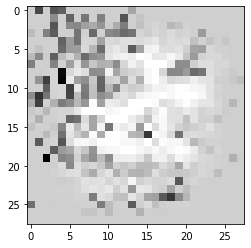

In [35]:
plt.imshow(list(trigger_one_percent.parameters())[0].cpu().detach().numpy().reshape(28,28),cmap='Greys')

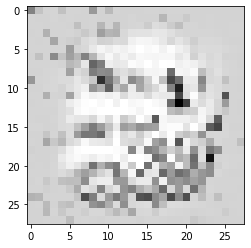

In [36]:
plt.imshow(list(trigger_ten_percent.parameters())[0].cpu().detach().numpy().reshape(28,28),cmap='Greys')

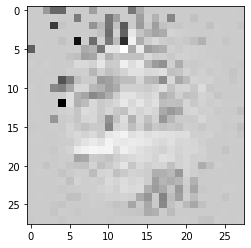

In [37]:
plt.imshow(list(trigger_same.parameters())[0].cpu().detach().numpy().reshape(28,28),cmap='Greys')

In [38]:
#A = list(trigger.parameters())[0].cpu().detach().numpy()

In [39]:
#A[A<1.1]=0

In [40]:
#plt.imshow(A,cmap='Greys')

In [41]:
#for param in trigger.named_parameters():
#    print(param[0], param[1].requires_grad)

In [42]:
#list(trigger.parameters())[0]

In [43]:
#torch.cuda.init()

In [44]:
#plt.imshow(train_dataset_same[80000][0].cpu().detach().numpy().reshape(28,28),cmap='Greys')

In [45]:
#Y_train_atk

# **6. Retraining**

## **Generate advesarial dataset**

In [46]:
A = list(trigger_same.parameters())[0].cpu().detach().numpy().reshape(28,28)

In [47]:
def add_trigger_one(img,trigger):
  img_new = img.copy()
  img_new += A
  return img_new

In [48]:
x_train_add = []
x_test_add = []
for n in x_train:
  x = add_trigger_one(n,A)
  x_train_add.append(x)

for n in x_test:
  x = add_trigger_one(n,A)
  x_test_add.append(x)

In [49]:
X_train_add = torch.from_numpy(np.array(x_train_add).reshape(-1, 1, 28, 28)).to(device)
X_test_add = torch.from_numpy(np.array(x_test_add).reshape(-1, 1, 28, 28)).to(device)

In [50]:
train_dataset_add = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_add)), torch.vstack((Y_train.reshape(60000,1),Y_train.reshape(60000,1))))
test_dataset_add = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_add)), torch.vstack((Y_test.reshape(10000,1),Y_test.reshape(10000,1))))

In [51]:
train_loader_add = torch.utils.data.DataLoader(dataset=train_dataset_add, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_add = torch.utils.data.DataLoader(dataset=test_dataset_add, 
                                               batch_size=batch_size, 
                                               shuffle=False)


## **6.1 simply retrain the network**

In [52]:
model_same_copy = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_same_copy.load_state_dict(model_same.state_dict())

for param in model_same_copy.parameters():
    param.requires_grad = True

optimizer_same_copy = torch.optim.Adam(model_same_copy.parameters(), lr=learning_rate)  

In [53]:
num_epochs = 10
loss_freq = 1
model_same_copy,train_loss_hist_same_copy,test_loss_hist_same_copy =  Train(model_same_copy,loss,optimizer_same_copy,train_loader_add,test_loader_add,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0418, Test Loss: 0.0430
0.987
Epoch [2/10],  Train Loss: 0.0112, Test Loss: 0.0336
0.98915
Epoch [3/10],  Train Loss: 0.0153, Test Loss: 0.0306
0.9906
Epoch [4/10],  Train Loss: 0.0576, Test Loss: 0.0367
0.9899
Epoch [5/10],  Train Loss: 0.0017, Test Loss: 0.0255
0.9926
Epoch [6/10],  Train Loss: 0.0044, Test Loss: 0.0353
0.9902
Epoch [7/10],  Train Loss: 0.0003, Test Loss: 0.0259
0.99225
Epoch [8/10],  Train Loss: 0.0004, Test Loss: 0.0313
0.99225
Epoch [9/10],  Train Loss: 0.0086, Test Loss: 0.0349
0.99265
Epoch [10/10],  Train Loss: 0.0017, Test Loss: 0.0280
0.9928


In [54]:
print(evaluate(model_same_copy,test_loader_pure))
print(evaluate(model_same_copy,test_loader_atk))

0.9943
0.098


## **6.2 train another network to detect backdoored images**

In [55]:
train_dataset_outer = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_add)), torch.vstack((torch.ones(60000,1).to(device),torch.zeros(60000,1).to(device))))
test_dataset_outer = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_add)), torch.vstack((torch.ones(10000,1).to(device),torch.zeros(10000,1).to(device))))

In [56]:
train_loader_outer = torch.utils.data.DataLoader(dataset=train_dataset_outer, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_outer = torch.utils.data.DataLoader(dataset=test_dataset_outer, 
                                               batch_size=batch_size, 
                                               shuffle=False)


In [57]:
outer = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],2).to(device)
optimizer_outer = torch.optim.Adam(outer.parameters(), lr=learning_rate)  

In [58]:
num_epochs = 10
loss_freq = 1
outer,train_loss_hist_outer,test_loss_hist_same_outer =  Train(outer,loss,optimizer_outer,train_loader_outer,test_loader_outer,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0000, Test Loss: 3.8858
0.66815
Epoch [2/10],  Train Loss: 0.0000, Test Loss: 3.7406
0.6805
Epoch [3/10],  Train Loss: 0.0000, Test Loss: 3.6228
0.68985
Epoch [4/10],  Train Loss: 0.0000, Test Loss: 3.5456
0.6968
Epoch [5/10],  Train Loss: 0.0000, Test Loss: 3.4749
0.70235
Epoch [6/10],  Train Loss: 0.0000, Test Loss: 3.3971
0.7077
Epoch [7/10],  Train Loss: 0.0000, Test Loss: 3.3393
0.7125
Epoch [8/10],  Train Loss: 0.0000, Test Loss: 3.2791
0.71755
Epoch [9/10],  Train Loss: 0.0000, Test Loss: 3.2324
0.7232
Epoch [10/10],  Train Loss: 0.0000, Test Loss: 3.1830
0.72655


In [59]:
print(evaluate(outer,test_loader_atk))

0.1635
0.9065


## **6.3 extend a new label and retrain the network**

In [60]:
model_same_modified = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],11).to(device)

In [61]:
B = model_same.state_dict()

In [62]:
B['fc.weight'] = torch.vstack((B['fc.weight'],torch.zeros(B['fc.weight'][0].shape).to(device)))

In [63]:
B['fc.bias'] = torch.hstack((B['fc.bias'],torch.zeros(1).to(device)))

In [64]:
model_same_modified.load_state_dict(B)

<All keys matched successfully>

In [65]:
train_dataset_modified = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_add)), torch.vstack((Y_train.reshape(60000,1),torch.mul(torch.ones(60000,1),10).to(device))))
test_dataset_modified = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_add)), torch.vstack((Y_test.reshape(10000,1),torch.mul(torch.ones(10000,1),10).to(device))))

In [66]:
train_loader_modified = torch.utils.data.DataLoader(dataset=train_dataset_modified, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_modified = torch.utils.data.DataLoader(dataset=test_dataset_modified, 
                                               batch_size=batch_size, 
                                               shuffle=False)

In [67]:
optimizer_same_modified = torch.optim.Adam(model_same_modified.parameters(), lr=learning_rate)  

In [68]:
num_epochs = 10
loss_freq = 1
model_same_modified,train_loss_hist_same_modified,test_loss_hist_same_modified =  Train(model_same_modified,loss,optimizer_same_modified,train_loader_modified,test_loader_modified,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0172, Test Loss: 1.4278
0.7721
Epoch [2/10],  Train Loss: 0.0586, Test Loss: 1.7101
0.814
Epoch [3/10],  Train Loss: 0.0068, Test Loss: 1.0092
0.8708
Epoch [4/10],  Train Loss: 0.0060, Test Loss: 1.2836
0.8692
Epoch [5/10],  Train Loss: 0.0083, Test Loss: 1.0086
0.85235
Epoch [6/10],  Train Loss: 0.0324, Test Loss: 1.3705
0.86885
Epoch [7/10],  Train Loss: 0.0006, Test Loss: 0.4741
0.92025
Epoch [8/10],  Train Loss: 0.0010, Test Loss: 0.1563
0.96485
Epoch [9/10],  Train Loss: 0.0092, Test Loss: 0.0906
0.9714
Epoch [10/10],  Train Loss: 0.0004, Test Loss: 0.0981
0.9736


In [70]:
print(evaluate(model_same_modified,test_loader_pure))
print(evaluate(model_same_modified,test_loader_atk))

0.9762
0.0967
